# CS 437/5317 - Deep Learning - PA3 - Part 2

In this part, we'll work with two datasets:
- STL-10, which is an image recognition dataset of `3x96x96` images. This dataset contains 500 training & 800 testing images per class, along with a massive unlabeled set of 100k images. However, you're only given half of them to ensure that training doesn't take forever lol. You can download it [here](https://pern-my.sharepoint.com/:u:/g/personal/24020389_lums_edu_pk/EcuDNMPuWY5MlIrbG-VwOXYBYNLpHz7MkG2Vw7WKVltnlw?e=E4lDqf).
- A 2D brain tumor segmentation dataset ([download link](https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation)). We'll be using an autoencoder to segment brain tumors from MRI brain images. This dataset contains 3064 pairs of MRI scans and their binary masks indicating tumor.

#### Import the required libraries and load the STL-10 dataset (only the train & test splits; the unlabeled images will be loaded later from the custom Dataset class implementation I've shared):

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm.notebook import tqdm
import numpy as np
import torchvision
from torch import nn, optim
!pip install torchsummary
from torchsummary import summary
from sklearn.model_selection import train_test_split
# from helper import (
#     transform,
#     training_loop_supervised,
#     training_loop_unsupervised,
#     training_loop_segmentation,
#     noisy_images,
#     visualize_reconstructions,
#     unlabeled_dataset
# )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128 # feel free to change this

# enter the path where you want to save the datasets
# make sure you save the unlabeled data in the same dir
path = fr'./'

os.chdir(path)



## helper.py STUFF

In [10]:
def training_loop_supervised(model, train_loader, test_loader, num_epochs,
                             criterion, optimizer, device, model_path):
    """
    Trains and evaluates a PyTorch image classification model, saving the model with the best accuracy on the test dataset.

    Args:
    - model: The PyTorch model to be trained and evaluated.
    - train_loader: DataLoader for the training data.
    - test_loader: DataLoader for the testing data.
    - num_epochs: Number of epochs to train the model.
    - criterion: Loss function used for training.
    - optimizer: Optimization algorithm used for training.
    - device: The device ('cuda' or 'cpu') to perform training and evaluation on.
    - model_path: Path to save the model achieving the best accuracy on the test set.

    Returns:
    - train_loss_history: List of average training losses for each epoch.
    - test_accuracy_history: List of test accuracies for each epoch.
    """
    print("HAAAAAAAAAAA")
    model.to(device)
    train_loss_history = []
    test_accuracy_history = []
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Evaluate on the test set
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        test_accuracy_history.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {avg_train_loss:.4f}, '
              f'Test Accuracy: {test_accuracy:.2%}')

        # Save the model if it has the best accuracy on the test set
        if test_accuracy == max(test_accuracy_history):
            torch.save(model.state_dict(), model_path)

    print('Training finished!')

    # Code here
    print("train_loss_history", train_loss_history)
    print("test_accuracy_history", test_accuracy_history)
    return train_loss_history, test_accuracy_history


def training_loop_unsupervised(model, task, train_loader, test_loader, num_epochs,
                             criterion, optimizer, device, model_path):
    """
    Trains and evaluates a PyTorch image classification model, saving the model with the best accuracy on the test dataset.

    Args:
    - model: The PyTorch model to be trained and evaluated.
    - task: string, either 'reconstruction' or 'denoising'
    - train_loader: DataLoader for the training data.
    - test_loader: DataLoader for the testing data.
    - num_epochs: Number of epochs to train the model.
    - criterion: Loss function used for training.
    - optimizer: Optimization algorithm used for training.
    - device: The device ('cuda' or 'cpu') to perform training and evaluation on.
    - model_path: Path to save the model achieving the best accuracy on the test set.

    Returns:
    - train_loss_history: List of average training losses for each epoch.
    - test_loss_history: List of test losses for each epoch.
    """
    model.to(device)
    train_loss_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for images, _ in train_loader:
            images = images.to(device)

            if task == 'denoising':
                noisy_imgs = add_gaussian_noise(images)  # Add Gaussian noise
                outputs = model(noisy_imgs)
            elif task == 'reconstruction':
                outputs = model(images)
            else:
                raise ValueError("Invalid task! Choose 'reconstruction' or 'denoising'.")

            loss = criterion(outputs, images)  # Calculate reconstruction loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Evaluate on the test set
        model.eval()
        total_test_loss = 0.0

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)

                if task == 'denoising':
                    noisy_imgs = add_gaussian_noise(images)  # Add Gaussian noise
                    outputs = model(noisy_imgs)
                elif task == 'reconstruction':
                    outputs = model(images)
                else:
                    raise ValueError("Invalid task! Choose 'reconstruction' or 'denoising'.")

                # Calculate reconstruction loss
                loss = criterion(outputs, images)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_history.append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}')

        # Save the model if it has the best test loss
        if avg_test_loss == min(test_loss_history):
            torch.save(model.state_dict(), model_path)

    print('Training finished!')

    return train_loss_history, test_loss_history



def noisy_images(images, mean=0.0, std=0.5):
    """
    Adds Gaussian noise to a batch of images.

    Parameters:
    - images: tensor of images of shape (N, C, H, W), where N is the batch size,
              C is the number of channels, H is the height, and W is the width.
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.

    Returns:
    - Tensor of noisy images of the same shape as the input.
    """
    # Code here
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    return noisy_images


def add_gaussian_noise(images, mean=0.0, std=0.5):
    """
    Adds Gaussian noise to a batch of images.

    Parameters:
    - images: tensor of images of shape (N, C, H, W), where N is the batch size,
              C is the number of channels, H is the height, and W is the width.
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.

    Returns:
    - Tensor of noisy images of the same shape as the input.
    """
    # Generate Gaussian noise with the same shape as the input images
    noise = torch.randn_like(images) * std + mean

    # Add the noise to the input images
    noisy_images = images + noise

    # Clamp the pixel values between 0 and 1
    noisy_images = torch.clamp(noisy_images, min=0.0, max=1.0)

    return noisy_images

def visualize_reconstructions(test_loader, model, device, task='reconstruction'):
    """
    Visualizes original and reconstructed images from a test dataset.

    Args:
    - test_loader: DataLoader for the test dataset.
    - model: Trained model for image reconstruction or denoising.
    - device: The device (e.g., 'cuda' or 'cpu') the model is running on.
    - task: The task to perform - either 'reconstruction' or 'denoising'.
    """
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    if task == 'denoising':
        images = noisy_images(images)  # Apply noise if the task is denoising

    recons = model(images.to(device))

    images_np = images.cpu().numpy()
    recons_np = recons.cpu().detach().numpy()

    indices = np.random.choice(images_np.shape[0], 9, replace=False)
    selected_images = images_np[indices]
    selected_recons = recons_np[indices]
    selected_labels = labels.numpy()[indices]

    fig, axs = plt.subplots(2, 9, figsize=(15, 4))

    for i in range(9):
        axs[0, i].imshow(np.transpose(selected_images[i], (1, 2, 0)), interpolation='none', cmap='gray')
        axs[0, i].set_title(f"GT: {selected_labels[i]}")
        axs[0, i].axis('off')

        axs[1, i].imshow(np.transpose(selected_recons[i], (1, 2, 0)), interpolation='none', cmap='gray')
        axs[1, i].set_title(f"Recon: {selected_labels[i]}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()




# Dataset class for Loading Unlabeled Images:
class UnlabeledImageDataset(Dataset):
    def __init__(self, folder, split='train', split_ratio=0.8):
        self.folder = folder
        self.imgs = os.listdir(folder)
        self.split = split
        self.split_ratio = split_ratio
        
        num_imgs = len(self.imgs)
        self.split_index = int(num_imgs * split_ratio)
        
        if split == 'train':
            self.imgs = self.imgs[:self.split_index]
        elif split == 'val':
            self.imgs = self.imgs[self.split_index:]

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.imgs[idx])
        img_np = cv2.imread(img_path)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        img_pt = Image.fromarray(img_np)  # Convert numpy array to PIL Image
        img_pt = transform(img_pt)  # Apply transformations
        return img_pt, 0    # adding a placeholder lablel
 
class UnlabeledImageDataset_2(Dataset):
    def __init__(self, folder, split='train', split_ratio=0.8):
        self.folder = folder
        self.transform = transform
        all_imgs = os.listdir(folder)
        num_imgs = len(all_imgs)
        split_index = int(num_imgs * split_ratio)

        if split == 'train':
            self.imgs = all_imgs[:split_index]
        elif split == 'val':
            self.imgs = all_imgs[split_index:]

        self.images = []
        for img_name in tqdm(self.imgs):
            img_path = os.path.join(self.folder, img_name)
            img_np = cv2.imread(img_path)
            img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                img_np = self.transform(img_np)
                
            self.images.append(img_np)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # since images are already preloaded, just retrieve from the list
        return self.images[idx]
    
def unlabeled_dataset(ram_above_16: bool = False):
    if ram_above_16:
        return UnlabeledImageDataset_2
    else:
        return UnlabeledImageDataset

def training_loop_segmentation(model, train_loader, val_loader, num_epochs,
                               criterion, optimizer, device, model_path):
    model.to(device)
    train_loss_history = []
    val_loss_history = []
    sample_outputs = []
    best_val_loss = float('inf')
    patience = 3  # Number of epochs to wait before early stopping if val loss doesn't improve
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader.dataset)
        train_loss_history.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                if len(sample_outputs) < 10:
                    sample_outputs.append({
                        'image': images[0],
                        'predicted_mask': outputs[0],
                        'ground_truth_mask': masks[0]
                    })

        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    return train_loss_history, val_loss_history, sample_outputs


In [4]:
# Load the STL-10 train and test datasets below:

# Define the path to your data
data_path = "/kaggle/input/stl-10/STL-10"

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])


class ImageLabelDataset(Dataset):
    def __init__(self, image_folder, labels, transform=None):
        self.image_folder = image_folder
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = ""
#         print(self.image_folder)
        if self.image_folder == "/kaggle/input/stl-10/STL-10/train_images":
            image_path = self.image_folder + f'/train_image_png_{idx+1}.png'    # i am doing +1 cz idk for some reasons loader was startign off with 0 which isn't in the dataset
        else:
            image_path = self.image_folder + f'/test_image_png_{idx+1}.png'    # i am doing +1 cz idk for some reasons loader was startign off with 0 which isn't in the dataset
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image at path: {image_path}")
            return None, None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting from BGR to RGB otherwise images were looking straight outta some horror movie
        image = Image.fromarray(image)  # Converting to PIL image cz apparently transform doesn't suppsort ndarray
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

train_labels = np.load('/kaggle/input/labels/train_labels.npy')
test_labels = np.load('/kaggle/input/labels/test_labels.npy')

train_dataset = ImageLabelDataset(data_path + '/train_images', train_labels, transform=transform)
test_dataset = ImageLabelDataset(data_path + '/test_images', test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("size of trainign images:",train_dataset.__len__())
print("size of testing images:",test_dataset.__len__())

size of trainign images: 5000
size of testing images: 8000


#### For now, we'll only work with the labeled data for supervised training. Let's visualize the data:

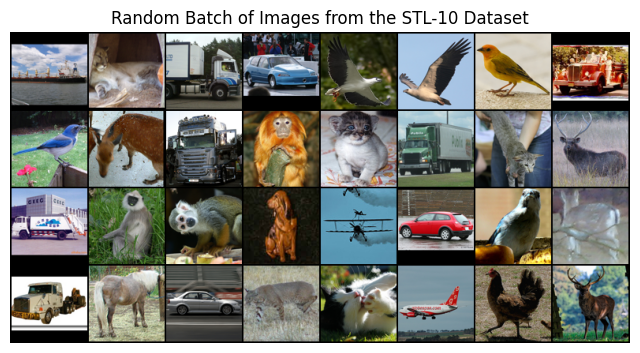

In [5]:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Random Batch of Images from the STL-10 Dataset")
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[0:32]))


## Task 1: Supervised Learning

Train a CNN Classifier on the training data and evaluate it on the test data. Add Convolutional layers, Batch Normalization, and Pooling layers in the convolutional block followed by a classifier layer.

In [6]:


class ClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=0),    #92
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=3, stride=3, padding=0),   # 30

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),   # 26
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=3, stride=3, padding=0),   # 8
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Tanh()
        )
        
    def forward(self, x):

        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [7]:
model = ClassifierCNN()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

summary(model, input_size=(3, 96, 96), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 92, 92]             608
              ReLU-2           [128, 8, 92, 92]               0
       BatchNorm2d-3           [128, 8, 92, 92]              16
         MaxPool2d-4           [128, 8, 30, 30]               0
            Conv2d-5          [128, 16, 26, 26]           3,216
              ReLU-6          [128, 16, 26, 26]               0
       BatchNorm2d-7          [128, 16, 26, 26]              32
         MaxPool2d-8            [128, 16, 8, 8]               0
            Linear-9                  [128, 64]          65,600
             ReLU-10                  [128, 64]               0
           Linear-11                  [128, 10]             650
             Tanh-12                  [128, 10]               0
Total params: 70,122
Trainable params: 70,122
Non-trainable params: 0
---------------------------------

#### Train your Model & Plot the Test accuracy history:

In [98]:
# Code here

criterion = torch.nn.CrossEntropyLoss()

# Define an optimizer (e.g., Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

# Device configuration
model.to(device)
model_path = fr"/kaggle/working/CNN_classifier_PA3_24100238.pth"
train_hist, test_hist = training_loop_supervised(model, train_loader, test_loader, num_epochs,
                                                 criterion, optimizer, device, model_path)

print("train_hist", train_hist)


HAAAAAAAAAAA
Epoch [1/20], Loss: 1.9028, Test Accuracy: 24.19%
Epoch [2/20], Loss: 1.6727, Test Accuracy: 39.30%
Epoch [3/20], Loss: 1.6033, Test Accuracy: 41.64%
Epoch [4/20], Loss: 1.5231, Test Accuracy: 41.74%
Epoch [5/20], Loss: 1.4532, Test Accuracy: 42.06%
Epoch [6/20], Loss: 1.3965, Test Accuracy: 47.40%
Epoch [7/20], Loss: 1.3315, Test Accuracy: 45.85%
Epoch [8/20], Loss: 1.2540, Test Accuracy: 49.66%
Epoch [9/20], Loss: 1.2003, Test Accuracy: 48.49%
Epoch [10/20], Loss: 1.1594, Test Accuracy: 48.44%
Epoch [11/20], Loss: 1.1360, Test Accuracy: 49.80%
Epoch [12/20], Loss: 1.0995, Test Accuracy: 50.91%
Epoch [13/20], Loss: 1.0457, Test Accuracy: 50.55%
Epoch [14/20], Loss: 1.0390, Test Accuracy: 45.07%
Epoch [15/20], Loss: 1.0526, Test Accuracy: 49.55%
Epoch [16/20], Loss: 1.0194, Test Accuracy: 50.81%
Epoch [17/20], Loss: 0.9945, Test Accuracy: 50.16%
Epoch [18/20], Loss: 0.9712, Test Accuracy: 50.85%
Epoch [19/20], Loss: 0.9643, Test Accuracy: 52.04%
Epoch [20/20], Loss: 0.9398

### Plotting Stuff

train loss 0.9450387433171272
test cc 54.775 %


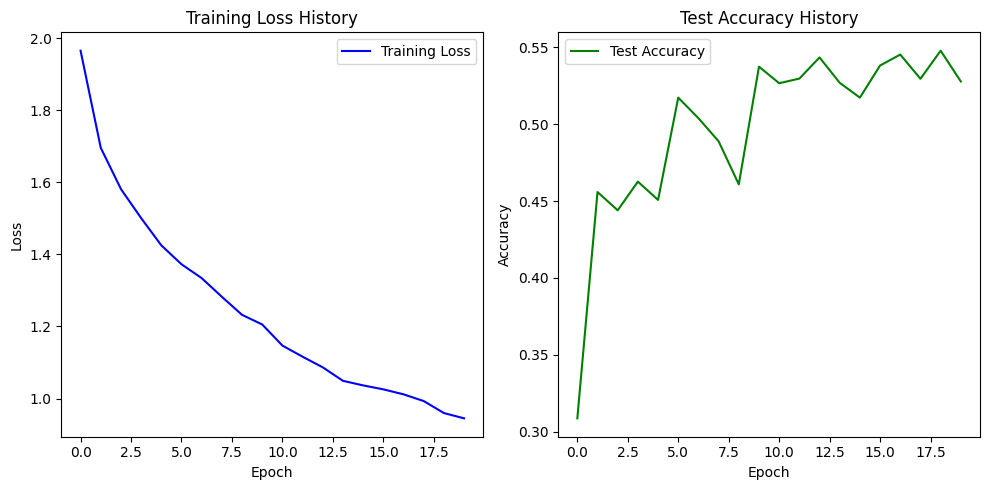

In [55]:
print("train loss", min(train_hist))
print("test cc", max(test_hist)*100, "%")

# Plot the training loss history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_hist, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()

# Plot the test accuracy history
plt.subplot(1, 2, 2)
plt.plot(test_hist, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()

### Small fun task: Let's evaluate a pre-trained Model (ResNET18) on the STL-10 data and see what accuracy we can achieve.

To use a pre-trained model, we first import it and its weights from `torchvision.models` and freeze the gradients of all the layers (because we want to use its learned embeddings that are trained on a massive dataset such as ImageNet) and then replace the final classifier layer with one that suits our specific problem (e.g. 10 classes in our case instead of the 1000 ImageNet Classes it's trained on).

In [114]:
from torchvision.models import resnet18, ResNet18_Weights

#### Read the documentation of this model. Look up the process of using a pre-trained model for your own dataset, and then train it on our labeled data.

In [115]:
model = resnet18(weights=ResNet18_Weights)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s] 


In [116]:
# Freeze gradients and replace the classifier layer:
for param in model.parameters():
    param.requires_grad = False

# Code here
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

### Train ResNet-18 & Plot the Accuracy History

In [146]:

# Code Here
criterion = torch.nn.CrossEntropyLoss()

# Define an optimizer (e.g., Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

# Device configuration
model.to(device)
model_path = fr"model_p2/delete_these_weights.pth"
train_hist, test_hist = training_loop_supervised(model, train_loader, test_loader, num_epochs,
                                                 criterion, optimizer, device, model_path)

print("train_hist", train_hist)

HAAAAAAAAAAA

Epoch [1/20], Loss: 1.2306, Test Accuracy: 73.38%

Epoch [2/20], Loss: 0.7405, Test Accuracy: 76.56%

Epoch [3/20], Loss: 0.6466, Test Accuracy: 76.75%

Epoch [4/20], Loss: 0.6200, Test Accuracy: 78.56%

Epoch [5/20], Loss: 0.5949, Test Accuracy: 78.06%

Epoch [6/20], Loss: 0.5562, Test Accuracy: 78.19%

Epoch [7/20], Loss: 0.5296, Test Accuracy: 77.71%

Epoch [8/20], Loss: 0.5198, Test Accuracy: 77.19%

Epoch [9/20], Loss: 0.5022, Test Accuracy: 77.48%

Epoch [10/20], Loss: 0.5061, Test Accuracy: 76.78%

Epoch [11/20], Loss: 0.4983, Test Accuracy: 78.54%

Epoch [12/20], Loss: 0.4849, Test Accuracy: 78.67%

Epoch [13/20], Loss: 0.4686, Test Accuracy: 77.83%

Epoch [14/20], Loss: 0.4664, Test Accuracy: 78.61%

Epoch [15/20], Loss: 0.4586, Test Accuracy: 78.49%

Epoch [16/20], Loss: 0.4634, Test Accuracy: 78.53%

Epoch [17/20], Loss: 0.4369, Test Accuracy: 77.55%

Epoch [18/20], Loss: 0.4413, Test Accuracy: 78.50%

Epoch [19/20], Loss: 0.4509, Test Accuracy: 76.61%

Epoch [

train loss 0.43688211680217914

test cc 78.675 %


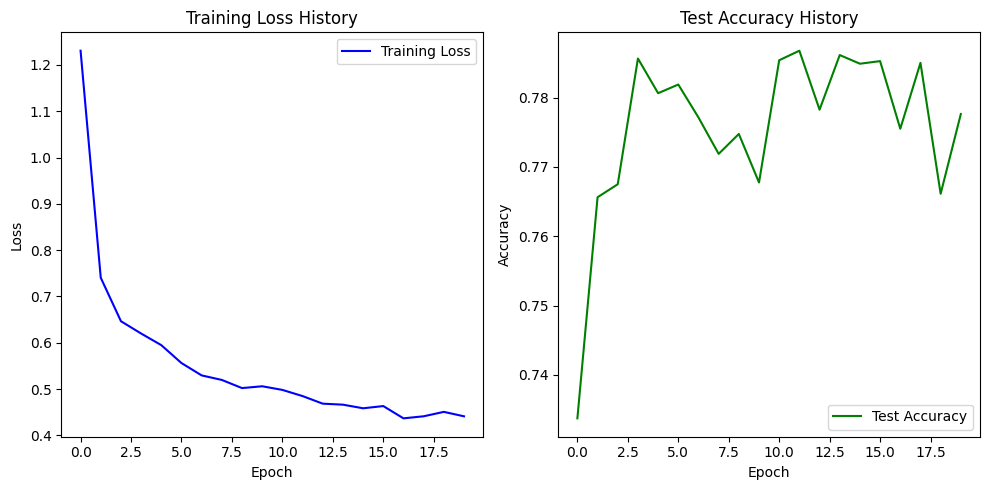

In [148]:
print("train loss", min(train_hist))
print("test cc", max(test_hist)*100, "%")

# Plot the training loss history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_hist, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()

# Plot the test accuracy history
plt.subplot(1, 2, 2)
plt.plot(test_hist, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()

## Task 2: Training an AutoEncoder with Unlabeled Data for Prediciton on Labeled Data

#### Anyway, back to creating our own models. In the next task, we will attempt to harness the power of self-supervised learning using an AutoEncoder.

The idea is to train a model to reconstruct (massive amounts of) unlabeled data in an unsupervised manner, and then use the encoder's learned embeddings to train the model on limited training data.

For this task, we will create a Deep Encoder-Decoder convolutional model. We'll train it on the unlabeled images from the STL-10 dataset, and then use the encoder with a classifier in another model class for classification.

**Note:** I recommend not using any pooling layers, as that leads to complications with storing the indices and putting them back into Unpooling layers. Just use a convolutional architecture.

In [8]:
class EncoderDecoderCNN(nn.Module):
    def __init__(self, in_chans=3, dropout_rate=0.2):
        super(EncoderDecoderCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_chans, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.ConvTranspose2d(32, in_chans, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# load the model
model = EncoderDecoderCNN()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
summary(model, input_size=(3, 96, 96), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 32, 96, 96]             896
              ReLU-2          [128, 32, 96, 96]               0
         Dropout2d-3          [128, 32, 96, 96]               0
            Conv2d-4          [128, 64, 96, 96]          18,496
              ReLU-5          [128, 64, 96, 96]               0
         Dropout2d-6          [128, 64, 96, 96]               0
            Conv2d-7         [128, 128, 96, 96]          73,856
              ReLU-8         [128, 128, 96, 96]               0
         Dropout2d-9         [128, 128, 96, 96]               0
  ConvTranspose2d-10          [128, 64, 96, 96]          73,792
             ReLU-11          [128, 64, 96, 96]               0
        Dropout2d-12          [128, 64, 96, 96]               0
  ConvTranspose2d-13          [128, 32, 96, 96]          18,464
             ReLU-14          [128, 32,

### Load the Dataset and train your AE model

no. of train batches 313
no. of val batches 79


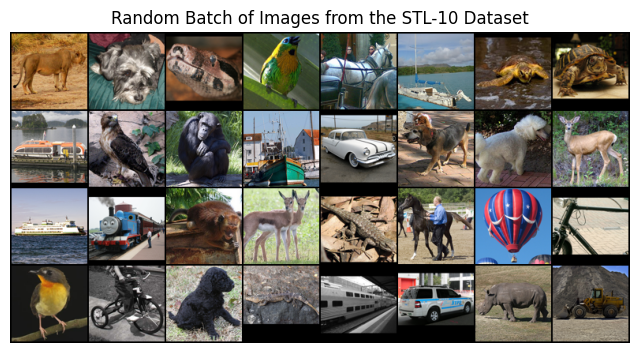

In [10]:
folder = "/kaggle/input/stl-10/STL-10/unlabeled_images" # change this to where your folder is

ram_above_16 = False # Set this to True if you have >= 16GB RAM

UnlabeledImageDataset = unlabeled_dataset(ram_above_16)
train_dataset = UnlabeledImageDataset(folder=folder, split='train')
val_dataset = UnlabeledImageDataset(folder=folder, split='val')

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("no. of train batches",len(train_loader))
print("no. of val batches",len(val_loader))

# Get a batch of training data
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[0:32]))

### Train Your Model

In [59]:
model = EncoderDecoderCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
# Epoch [1/20], Train Loss: 0.0083, Test Loss: 0.0092

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model_path = fr"/kaggle/working/EncoderDecoderCNN_weights.pth"
train_loss_history, test_loss_history = training_loop_unsupervised(model, 'reconstruction', train_loader, test_loader, num_epochs, criterion, optimizer, device, model_path)

print("train_hist", train_loss_history)

Epoch [1/20], Train Loss: 0.0170, Test Loss: 0.0071
Epoch [2/20], Train Loss: 0.0068, Test Loss: 0.0091
Epoch [3/20], Train Loss: 0.0051, Test Loss: 0.0062
Epoch [4/20], Train Loss: 0.0042, Test Loss: 0.0068
Epoch [5/20], Train Loss: 0.0038, Test Loss: 0.0049
Epoch [6/20], Train Loss: 0.0035, Test Loss: 0.0057
Epoch [7/20], Train Loss: 0.0034, Test Loss: 0.0080
Epoch [8/20], Train Loss: 0.0032, Test Loss: 0.0064
Epoch [9/20], Train Loss: 0.0032, Test Loss: 0.0074
Epoch [10/20], Train Loss: 0.0030, Test Loss: 0.0075
Epoch [11/20], Train Loss: 0.0029, Test Loss: 0.0063
Epoch [12/20], Train Loss: 0.0029, Test Loss: 0.0063
Epoch [13/20], Train Loss: 0.0028, Test Loss: 0.0060
Epoch [14/20], Train Loss: 0.0028, Test Loss: 0.0091
Epoch [15/20], Train Loss: 0.0028, Test Loss: 0.0060
Epoch [16/20], Train Loss: 0.0027, Test Loss: 0.0060
Epoch [17/20], Train Loss: 0.0027, Test Loss: 0.0079
Epoch [18/20], Train Loss: 0.0027, Test Loss: 0.0053
Epoch [19/20], Train Loss: 0.0026, Test Loss: 0.0052
Ep

### plotting losses

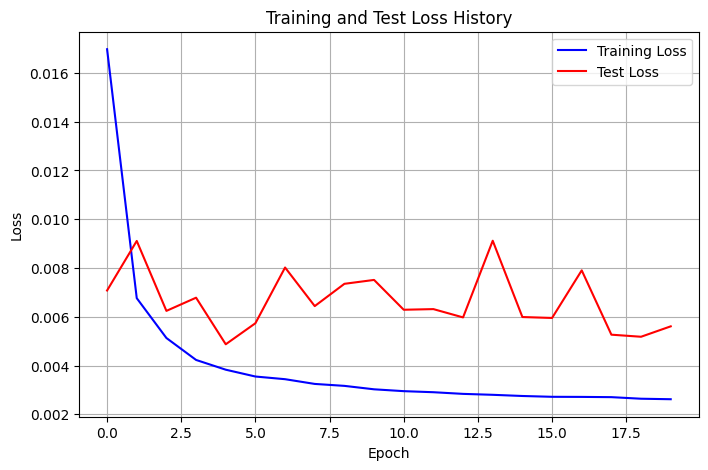

In [60]:
# Code here
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss History')
plt.legend()
plt.grid(True)
plt.show()

### Visualize 9 random images and their reconstructions using `plt.subplots`.

Note: it's fine if they're horrible reconstructions, that's expected from a simple Convolutional AE

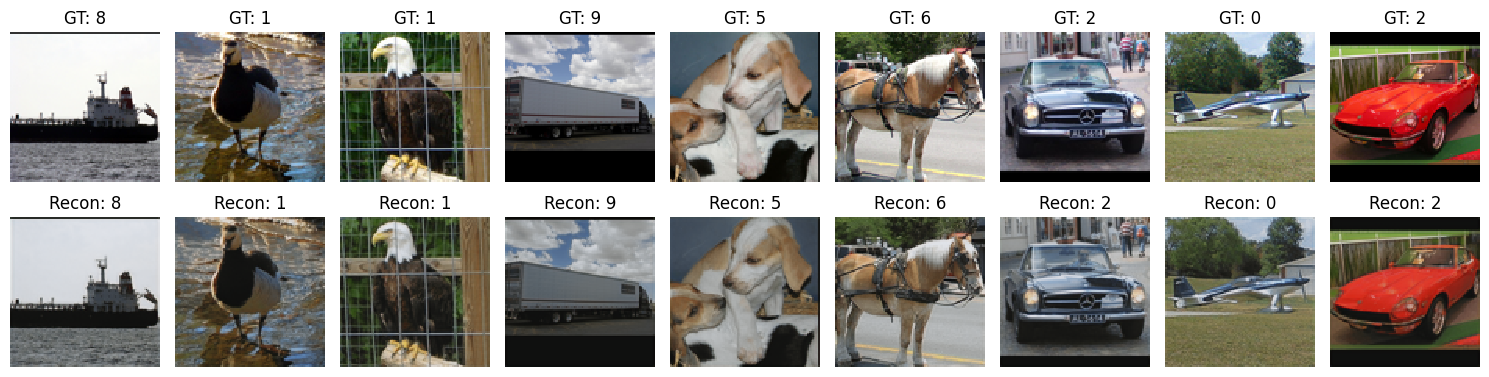

In [61]:
# Code here
visualize_reconstructions(test_loader, model, device, 'reconstruction')

#### Now, use the encoder from this AE (freeze its gradients) with a classifier layer to train the model.

In [18]:
class EncoderClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(EncoderClassifier, self).__init__()
        # Use the pretrained encoder and freeze its parameters
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Add a classifier layer
        self.classifier = nn.Sequential(
            nn.Linear(128 * 96 * 96, 10),
            nn.Tanh()
        )
        

    def forward(self, x):
        # Move input tensor to the same device as the encoder's parameters
        x = x.to(next(self.encoder.parameters()).device)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the encoder
        x = self.classifier(x)
        return x


In [19]:
# Declare the model & print a summary
# load the model
# Load the pretrained autoencoder model
autoencoder = EncoderDecoderCNN()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder.to(device)


# Use the encoder part of the autoencoder in the EncoderClassifier
encoder_classifier = EncoderClassifier(autoencoder.encoder, num_classes=10)
encoder_classifier.to(device)

# Print model summary
summary(encoder_classifier, input_size=(3, 96, 96), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 32, 96, 96]             896
              ReLU-2          [128, 32, 96, 96]               0
         Dropout2d-3          [128, 32, 96, 96]               0
            Conv2d-4          [128, 64, 96, 96]          18,496
              ReLU-5          [128, 64, 96, 96]               0
         Dropout2d-6          [128, 64, 96, 96]               0
            Conv2d-7         [128, 128, 96, 96]          73,856
              ReLU-8         [128, 128, 96, 96]               0
         Dropout2d-9         [128, 128, 96, 96]               0
           Linear-10                  [128, 10]      11,796,490
             Tanh-11                  [128, 10]               0
Total params: 11,889,738
Trainable params: 11,796,490
Non-trainable params: 93,248
----------------------------------------------------------------
Input size (MB): 13

In [21]:
# create dataloaders again for the train and test split of the STL-10 dataset

# Code here
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Train your model

In [22]:
# Code here

# Assuming you have the model, criterion, optimizer, train_loader, and test_loader ready
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # Adjust as needed

model_path = fr"/kaggle/working/EncoderClassifier_weights.pth"
train_loss_history, test_loss_history = training_loop_supervised(encoder_classifier, train_loader, test_loader, num_epochs, criterion, optimizer, device, model_path)

print("train_hist", train_loss_history)

HAAAAAAAAAAA
Epoch [1/10], Loss: 2.2756, Test Accuracy: 8.45%
Epoch [2/10], Loss: 2.2757, Test Accuracy: 8.45%
Epoch [3/10], Loss: 2.2756, Test Accuracy: 8.45%
Epoch [4/10], Loss: 2.2756, Test Accuracy: 8.45%
Epoch [5/10], Loss: 2.2756, Test Accuracy: 8.45%
Epoch [6/10], Loss: 2.2756, Test Accuracy: 8.45%
Epoch [7/10], Loss: 2.2758, Test Accuracy: 8.45%
Epoch [8/10], Loss: 2.2755, Test Accuracy: 8.45%
Epoch [9/10], Loss: 2.2755, Test Accuracy: 8.45%
Epoch [10/10], Loss: 2.2755, Test Accuracy: 8.45%
Training finished!
train_loss_history [2.2756292446733664, 2.275699846279888, 2.2755602723874224, 2.275617965113241, 2.27562150102073, 2.2755660660350667, 2.2757779218899175, 2.2755156797342027, 2.275527234275501, 2.275458030426464]
test_accuracy_history [0.0845, 0.0845, 0.0845, 0.0845, 0.0845, 0.0845, 0.0845, 0.0845, 0.0845, 0.0845]
train_hist [2.2756292446733664, 2.275699846279888, 2.2755602723874224, 2.275617965113241, 2.27562150102073, 2.2755660660350667, 2.2757779218899175, 2.2755156797

## Task 3: Brain Tumor Segmentation 

In this task, you'll be training an AE model to segment brain tumors from patients' MRI scans. The ground truth will be the binary mask, and the output of the Decoder layer must be between 0 and 1 as well for all elements. Import the images, do preprocessing as you see fit (note that all images and their masks must be scaled to `240x240` resolution), and write an AutoEncoder Model that takes in the MRI scan as an input image and returns the binary segmentation mask of the same resolution (`1x240x240`). You'll need to ensure that the AE model is symmetrical, and account for input and output paddings for resolution consistency between inputs and outputs.

### Import the images & their masks and store them as lists

In [3]:
# Define image and ground truth directories
image_dir = '/kaggle/input/brain-tumor/images'
ground_truths_dir = '/kaggle/input/brain-tumor/masks'
# Function for preprocessing images and masks
def preprocessing(image, mask):
    # Resize images and masks to 240x240
    image = cv2.resize(image, (240, 240))
    mask = cv2.resize(mask, (240, 240))
    
    # Normalize image to range [0, 1]
    image = image / 255.0
    
    # Convert mask to binary values
    mask = np.where(mask > 0, 1, 0)

    trnasform = transforms.ToTensor()
    
    # # Convert image and mask to PyTorch tensors
    image = trnasform(image)
    mask = trnasform(mask)
    
    return image, mask

# Load images and ground truths
data = []
ground_truths = []
for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(ground_truths_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if image is not None and mask is not None:
            image_preprocessed, mask_preprocessed = preprocessing(image, mask)
            data.append(image_preprocessed)
            ground_truths.append(mask_preprocessed)

# Convert data and ground truths to PyTorch dataset
class TumorDataset(Dataset):
    def __init__(self, data, ground_truths):
        self.data = data
        self.ground_truths = ground_truths

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.ground_truths[idx]



### Do an 80-20 train-test split & create dataloaders:

In [4]:
# Code here:
# Define the dataset
dataset = TumorDataset(data, ground_truths)

# Create train-test split
indices = np.arange(len(dataset))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create Subset datasets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Print number of batches
print("Number of train batches:", len(train_loader))
print("Number of test batches:", len(test_loader))

Number of train batches: 2451
Number of test batches: 613


### Visualize a random set of images along with their corresponding binary masks

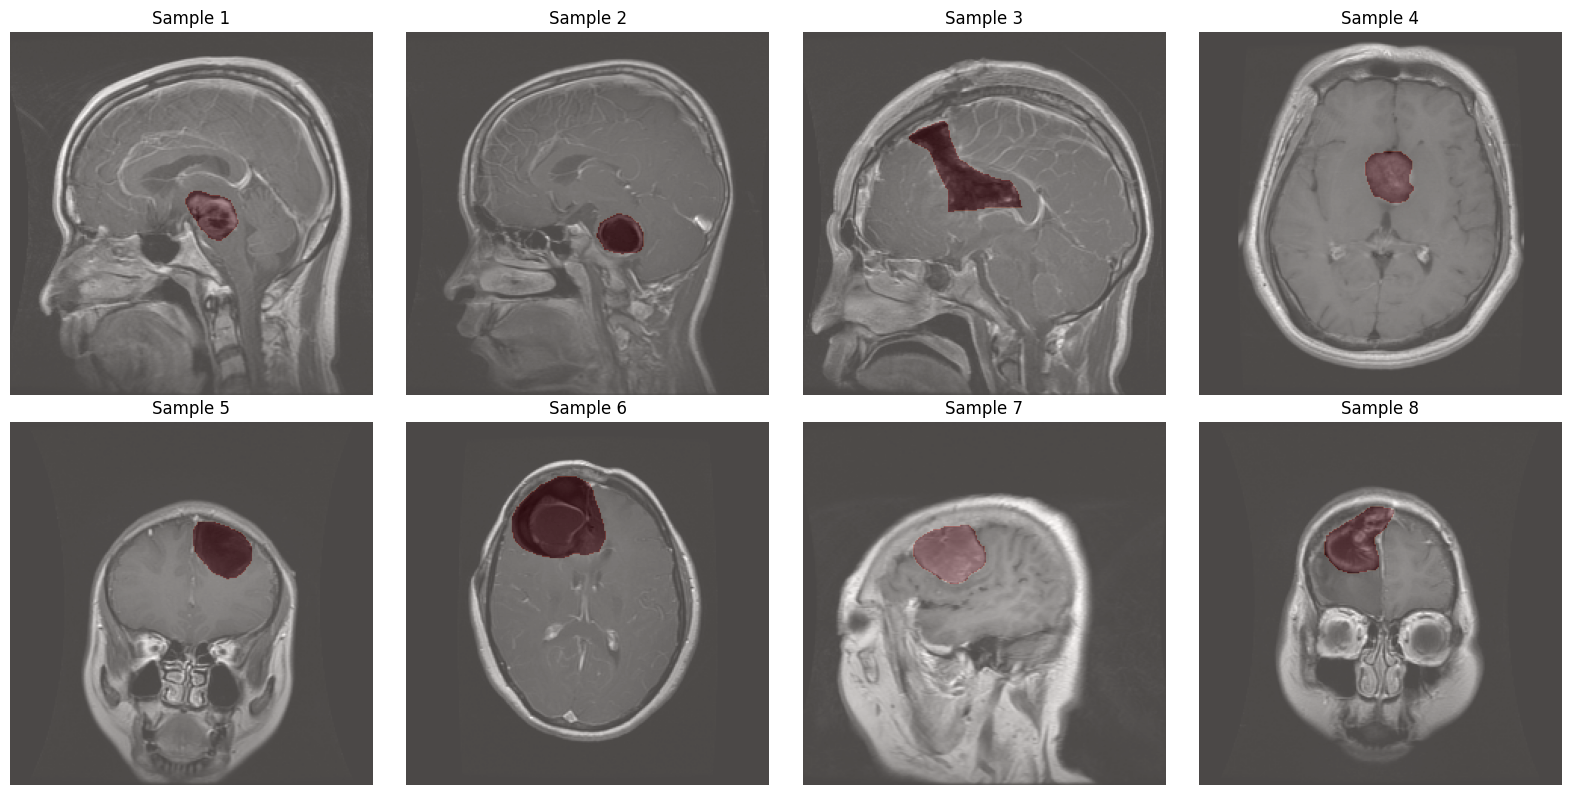

In [5]:
# Function to visualize images and masks
def visualize_samples(images, masks):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=2, ncols=num_samples // 2, figsize=(16, 8))

    for i, (image, mask) in enumerate(zip(images, masks)):
        # Squeeze the singleton dimension
        image = image.squeeze(0)
        mask = mask.squeeze(0)

        ax = axes[i // (num_samples // 2), i % (num_samples // 2)]
        ax.imshow(image, cmap='gray')
        ax.imshow(mask, alpha=0.3, cmap='Reds')
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()


# Select 8 random samples from the training dataset
random_indices = np.random.choice(len(train_dataset), 8, replace=False)
random_samples = [(train_dataset[i][0], train_dataset[i][1]) for i in random_indices]

# Separate images and masks
random_images = [sample[0] for sample in random_samples]
random_masks = [sample[1] for sample in random_samples]

# Visualize the random samples
visualize_samples(random_images, random_masks)


### Create a Training Loop for segmentation tasks in `helper.py`. 
Note: You must also store & return 2 sample outputs of the model after every 5 epochs. We'll use them to visualize how the model learns to segment the images over the training process.

#### For segmentation tasks, an MSE Loss function, while usable, often performs poorly. Your next task is to implement the Dice Loss using a custom `DiceLoss` class. 


$\text{Given a predicted mask }  p \text{ and the ground truth target } t, \text{ with a smoothing factor } s, \text{ the Dice Loss } L \text{ is defined as:}$

#### $L = 1 - \frac{2 \cdot \sum(p \cdot t) + s}{\sum(p^{2}) + \sum(t^{2}) + s}$

The smoothing factor is a very small number added to avoid division by 0. You can read more about Dice Loss [here](https://arxiv.org/pdf/1606.04797.pdf) (on page 6).


In [6]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, prediction, target, smooth=1):
        prediction = prediction.view(-1)  # Flatten prediction tensor
        target = target.view(-1)          # Flatten target tensor

        # Resize prediction tensor to match the size of the target tensor
        if prediction.shape[0] != target.shape[0]:
            prediction = torch.nn.functional.interpolate(prediction.unsqueeze(0), size=target.shape, mode='nearest').squeeze(0)

        # Calculate intersection and union
        intersection = torch.sum(prediction * target)
        union = torch.sum(prediction) + torch.sum(target)

        # Calculate Dice coefficient
        dice = (2. * intersection + smooth) / (union + smooth)

        return 1 - dice


### Create an AutoEncoder Model for Brain Tumor Segmentation

In [12]:
class EncoderDecoderCNN(nn.Module):
    def __init__(self):
        super(EncoderDecoderCNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        # Encoder
        x, indices = self.encoder(x)
        # Decoder
        out = self.unpool(x, indices)
        x = self.decoder(out)
        return x

In [15]:
# load the model
model = EncoderDecoderCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, input_size=(1, 240, 240), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [128, 8, 240, 240]              80
       BatchNorm2d-2         [128, 8, 240, 240]              16
              ReLU-3         [128, 8, 240, 240]               0
            Conv2d-4        [128, 16, 240, 240]           1,168
       BatchNorm2d-5        [128, 16, 240, 240]              32
              ReLU-6        [128, 16, 240, 240]               0
            Conv2d-7        [128, 32, 240, 240]           4,640
       BatchNorm2d-8        [128, 32, 240, 240]              64
              ReLU-9        [128, 32, 240, 240]               0
           Conv2d-10        [128, 64, 240, 240]          18,496
      BatchNorm2d-11        [128, 64, 240, 240]             128
             ReLU-12        [128, 64, 240, 240]               0
           Conv2d-13       [128, 128, 238, 238]         204,928
      BatchNorm2d-14       [128, 128, 2

### Train your Model & Plot the Loss History:

In [16]:
criterion = DiceLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

model_path = "/kaggle/working/SegmentEnc.pth" # change this
train_hist, test_hist, sample_outputs = training_loop_segmentation(model, train_loader, test_loader, num_epochs,
                                                 criterion, optimizer, device, model_path)



Epoch 1/10, Train Loss: 0.7935152488161427, Val Loss: 0.8107083570120969
Epoch 2/10, Train Loss: 0.7114206348473274, Val Loss: 0.872846588516702
Epoch 3/10, Train Loss: 0.6663460190419711, Val Loss: 0.851776176525757
Epoch 4/10, Train Loss: 0.6192047533965607, Val Loss: 0.7437475247834285
Epoch 5/10, Train Loss: 0.5757941319134128, Val Loss: 0.8580970169086052
Epoch 6/10, Train Loss: 0.5470284489844099, Val Loss: 0.727199416759547
Epoch 7/10, Train Loss: 0.518083767835484, Val Loss: 0.6956195495840387
Epoch 8/10, Train Loss: 0.5029468599848239, Val Loss: 0.7183774099069941
Epoch 9/10, Train Loss: 0.4787326932245252, Val Loss: 0.7595636217473576
Epoch 10/10, Train Loss: 0.46829051897993673, Val Loss: 0.6783715932832067


## PLotting

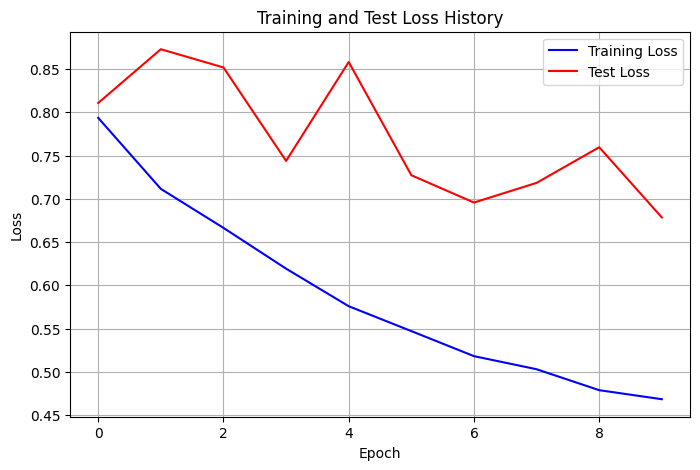

In [17]:
# Code here
plt.figure(figsize=(8, 5))
plt.plot(train_hist, label='Training Loss', color='blue')
plt.plot(test_hist, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss History')
plt.legend()
plt.grid(True)
plt.show()

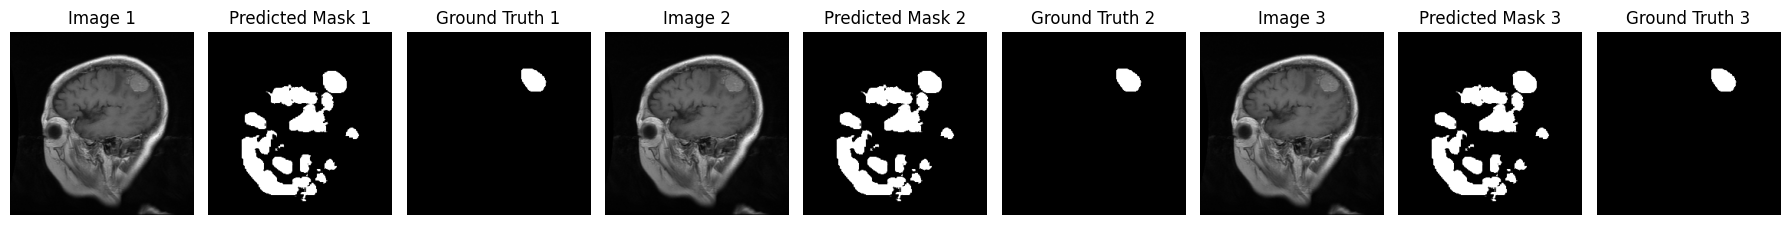

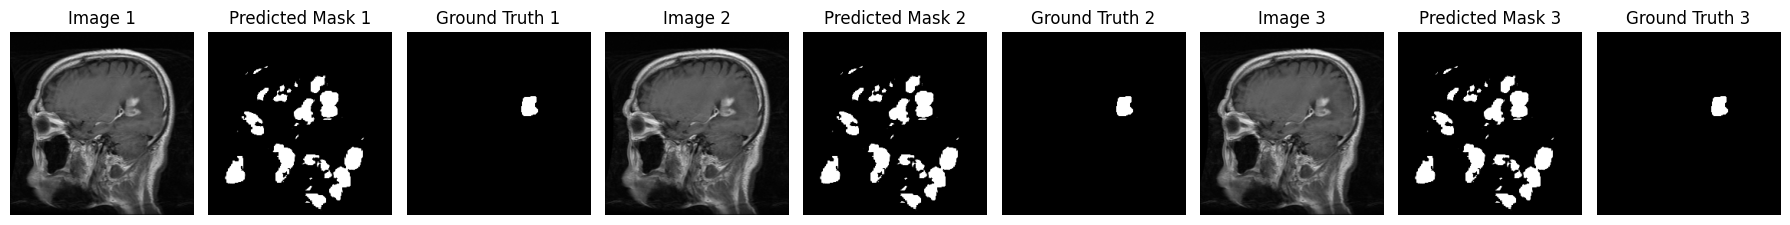

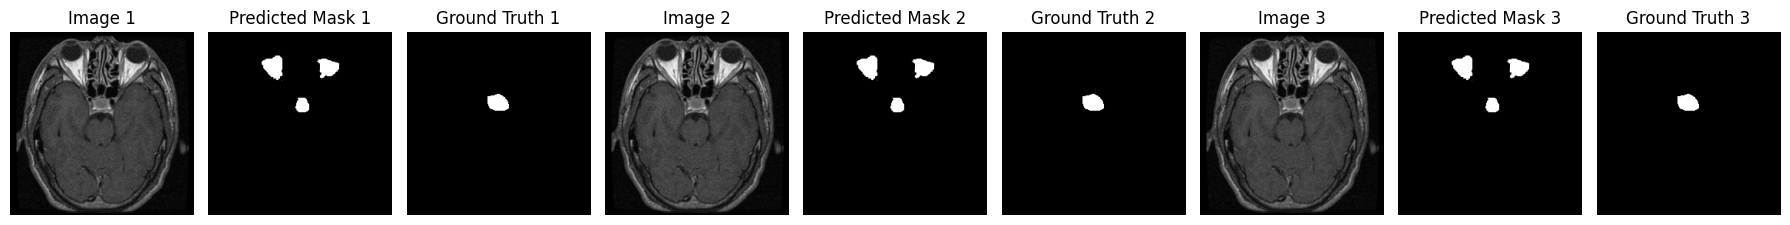

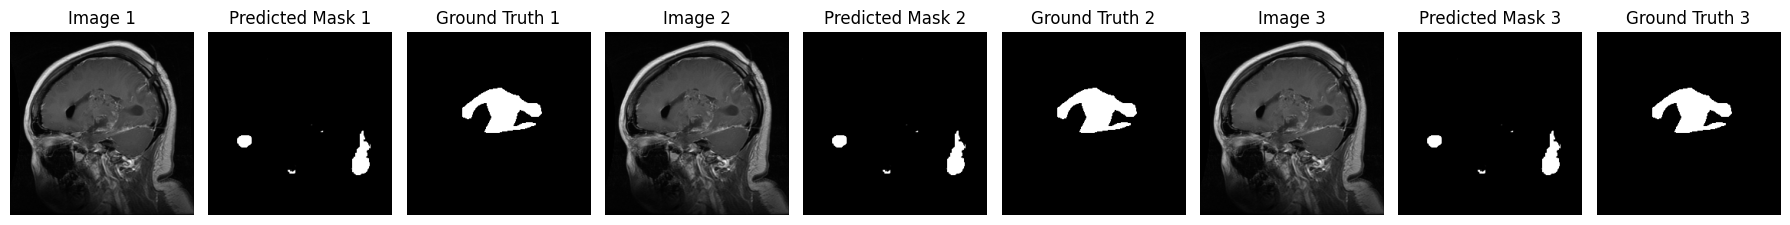

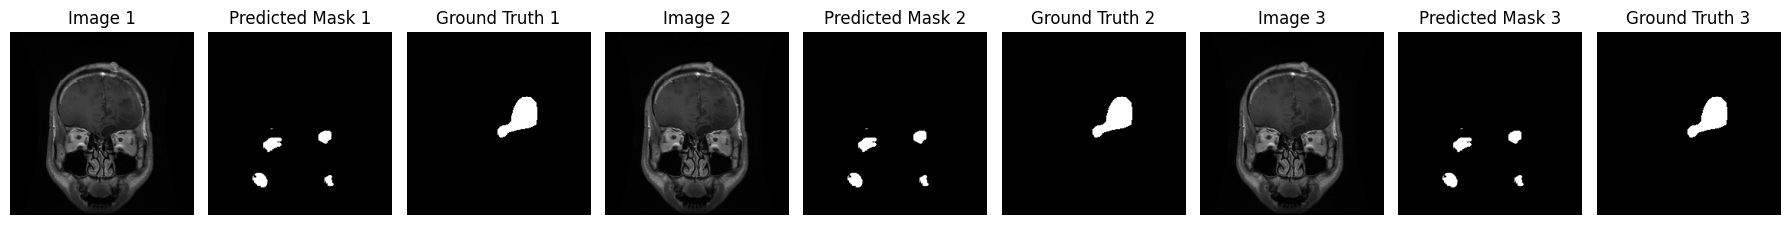

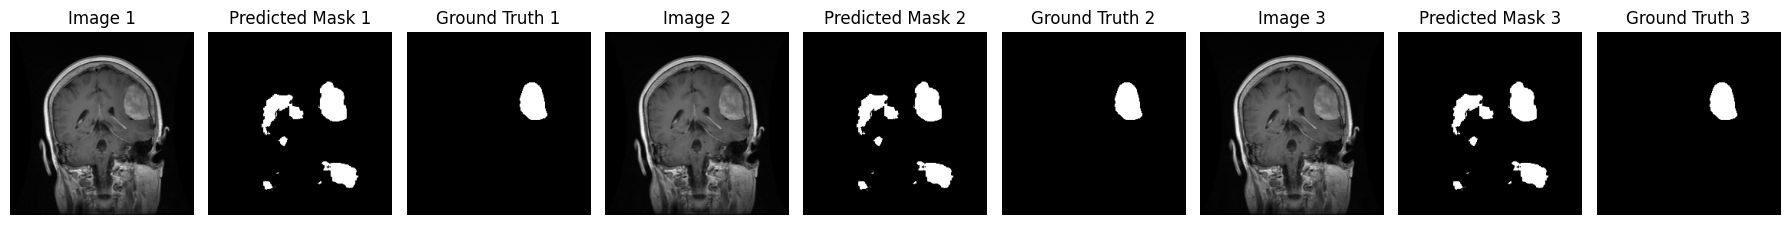

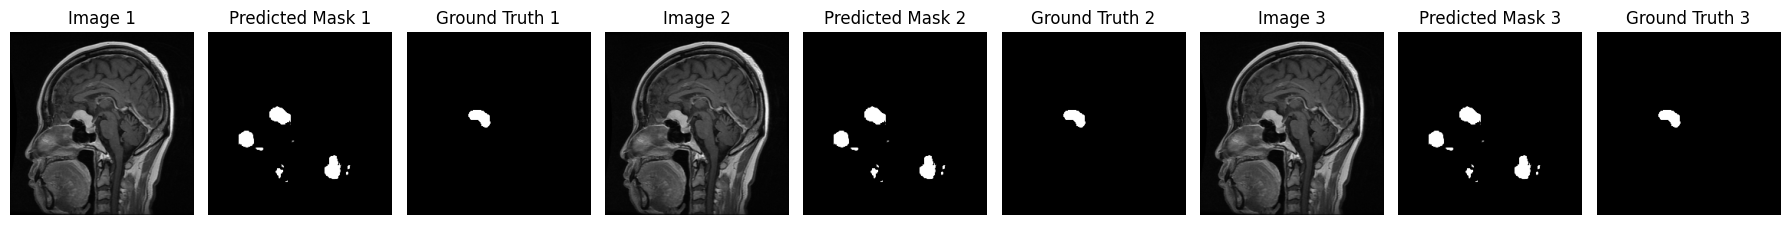

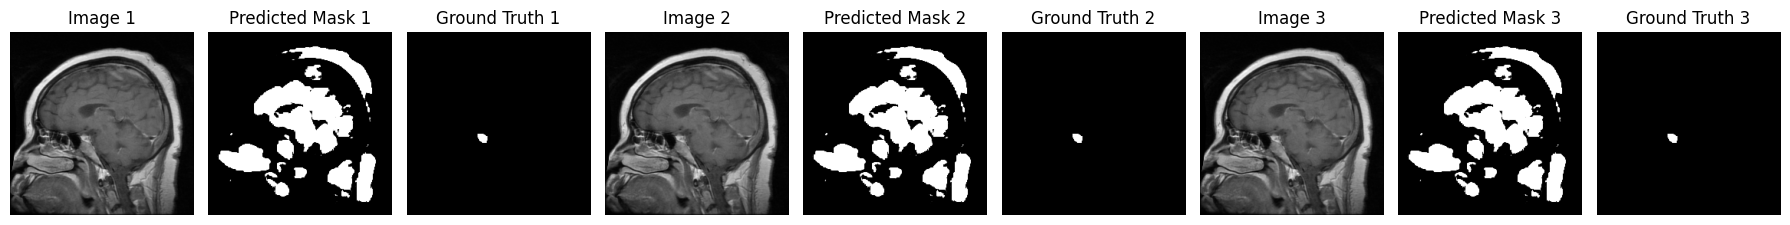

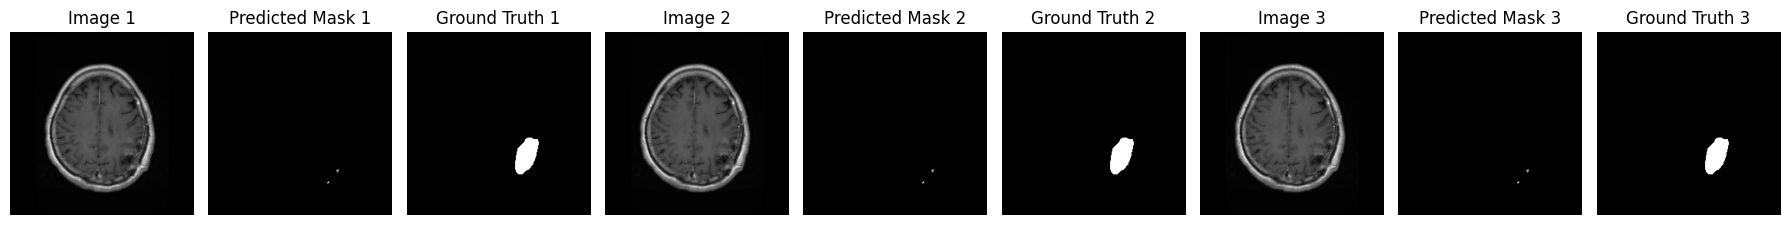

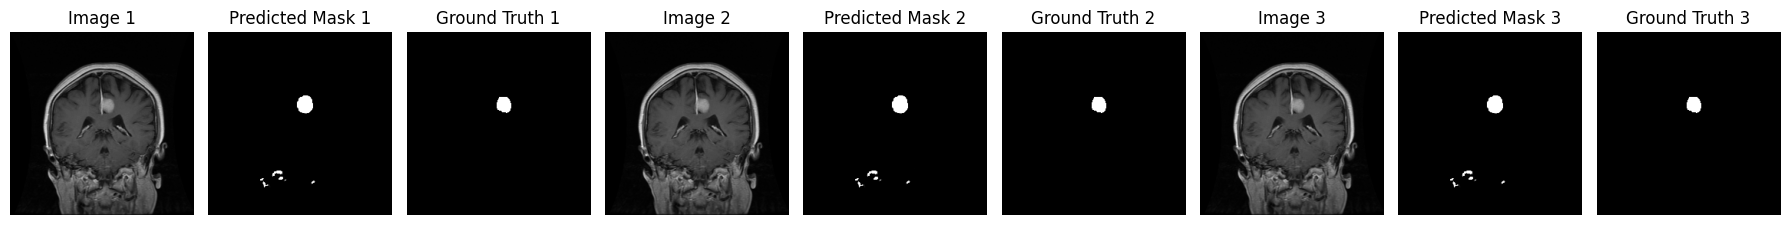

In [18]:
def visualize_sample_outputs(sample_outputs):
    """
    Visualizes sample outputs (images, predicted masks, and ground truth masks) in a single row for each set of samples.

    Args:
    - sample_outputs: List of dictionaries containing images, predicted masks, and ground truth masks for sample outputs.
    """

    for samples in sample_outputs:
        num_samples = len(samples)
        num_cols = num_samples * 3  # Three columns per sample (image, predicted mask, ground truth mask)

        fig, axs = plt.subplots(1, num_cols, figsize=(num_samples * 6, 4))

        for i, _ in enumerate(samples):
            image = samples['image'].squeeze().cpu().numpy()
            predicted_mask = samples['predicted_mask'].squeeze().cpu().numpy()
            ground_truth_mask = samples['ground_truth_mask'].squeeze().cpu().numpy()

            # Plotting image
            axs[i * 3].imshow(image, cmap='gray')
            axs[i * 3].set_title(f'Image {i+1}')
            axs[i * 3].axis('off')

            # Plotting predicted mask
            axs[i * 3 + 1].imshow(predicted_mask, cmap='gray')
            axs[i * 3 + 1].set_title(f'Predicted Mask {i+1}')
            axs[i * 3 + 1].axis('off')

            # Plotting ground truth mask
            axs[i * 3 + 2].imshow(ground_truth_mask, cmap='gray')
            axs[i * 3 + 2].set_title(f'Ground Truth {i+1}')
            axs[i * 3 + 2].axis('off')

        plt.tight_layout()
        plt.show()

# Assuming sample_outputs is defined elsewhere
# print(type(sample_outputs[0]))
visualize_sample_outputs(sample_outputs)

In [ ]:
print(type(sample_outputs[0]))
visualize_sample_outputs(sample_outputs)

#### Use the IoU and DICE Coefficient to evaluate your model (Read [here](https://medium.com/mlearning-ai/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f)):

In [30]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [28]:
true = []
pred = []
for imgs, mask in test_loader:
    true.extend([m.cpu().numpy().reshape(1, 240, 240) for m in mask])
    with torch.no_grad():
        imgs = imgs.reshape(-1, 1, 240, 240).cuda().float()  # Cast input to float
        outputs = model(imgs).detach().cpu().numpy()
    pred.extend([m for m in outputs])

true = np.array(true)
pred = np.array(pred)


In [29]:
print("Dice coefficient is:",dice_coef(true,pred))
print("IoU:", iou(true,pred))

Dice coefficient is: 0.148
IoU: 0.521
